
# Alpha Factor Evaluation

This notebook illustrates the following steps:
- Evaluate the predictive content of your financial features with respect to the 1-day forward returns using several metrics, including:
- the information coefficient (i.e., the Spearman rank correlation)
- the mutual information
- the LightGBM feature importance, computed by training a gradient boosting model with default settings on the first nine years of data 
- SHAP values computed from the LightGBM model (see resources)
- Alphalens quantile-based return spreads (see resources)

These different metrics will yield different and even conflicting answers. Take some time to think about why this is the case, and which approach(es) would likely be most effective when aiming to select the most predictive features?  

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os, sys
from time import time

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import scale
import lightgbm as lgb
from scipy.stats import spearmanr
import shap

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens import plotting
from alphalens import performance as perf
from alphalens import utils

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

In [4]:
MONTH = 21
YEAR = 252

## Load Data

In [5]:
DATA_STORE = '../data/stock_prices.h5'

In [6]:
with pd.HDFStore(DATA_STORE) as store:
    data = store['model_data']

data = data.drop(['open', 'high', 'low', 'volume'] , axis=1).sort_index()
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2042677 entries, ('A', Timestamp('2000-01-03 00:00:00')) to ('ZMH', Timestamp('2015-06-25 00:00:00'))
Data columns (total 52 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   close           2042677 non-null  float64
 1   ret_01          2042207 non-null  float64
 2   ret_03          2041267 non-null  float64
 3   ret_05          2040327 non-null  float64
 4   ret_10          2037977 non-null  float64
 5   ret_21          2032807 non-null  float64
 6   ret_42          2022937 non-null  float64
 7   ret_63          2013067 non-null  float64
 8   ret_126         1983457 non-null  float64
 9   ret_252         1924237 non-null  float64
 10  BB_UP           2033747 non-null  float64
 11  BB_LOW          2033747 non-null  float64
 12  BB_SQUEEZE      2033747 non-null  float64
 13  PLUS_DI         2036097 non-null  float64
 14  MINUS_DI        2036097 non-null  float64
 15  ADX        

## Factor Correlation

Which features are most alike in terms of their (rank) correlation?

In [7]:
feature_correlation = data.corr()   # method='spearman' to use instead of pearson which is default. But it takes too long

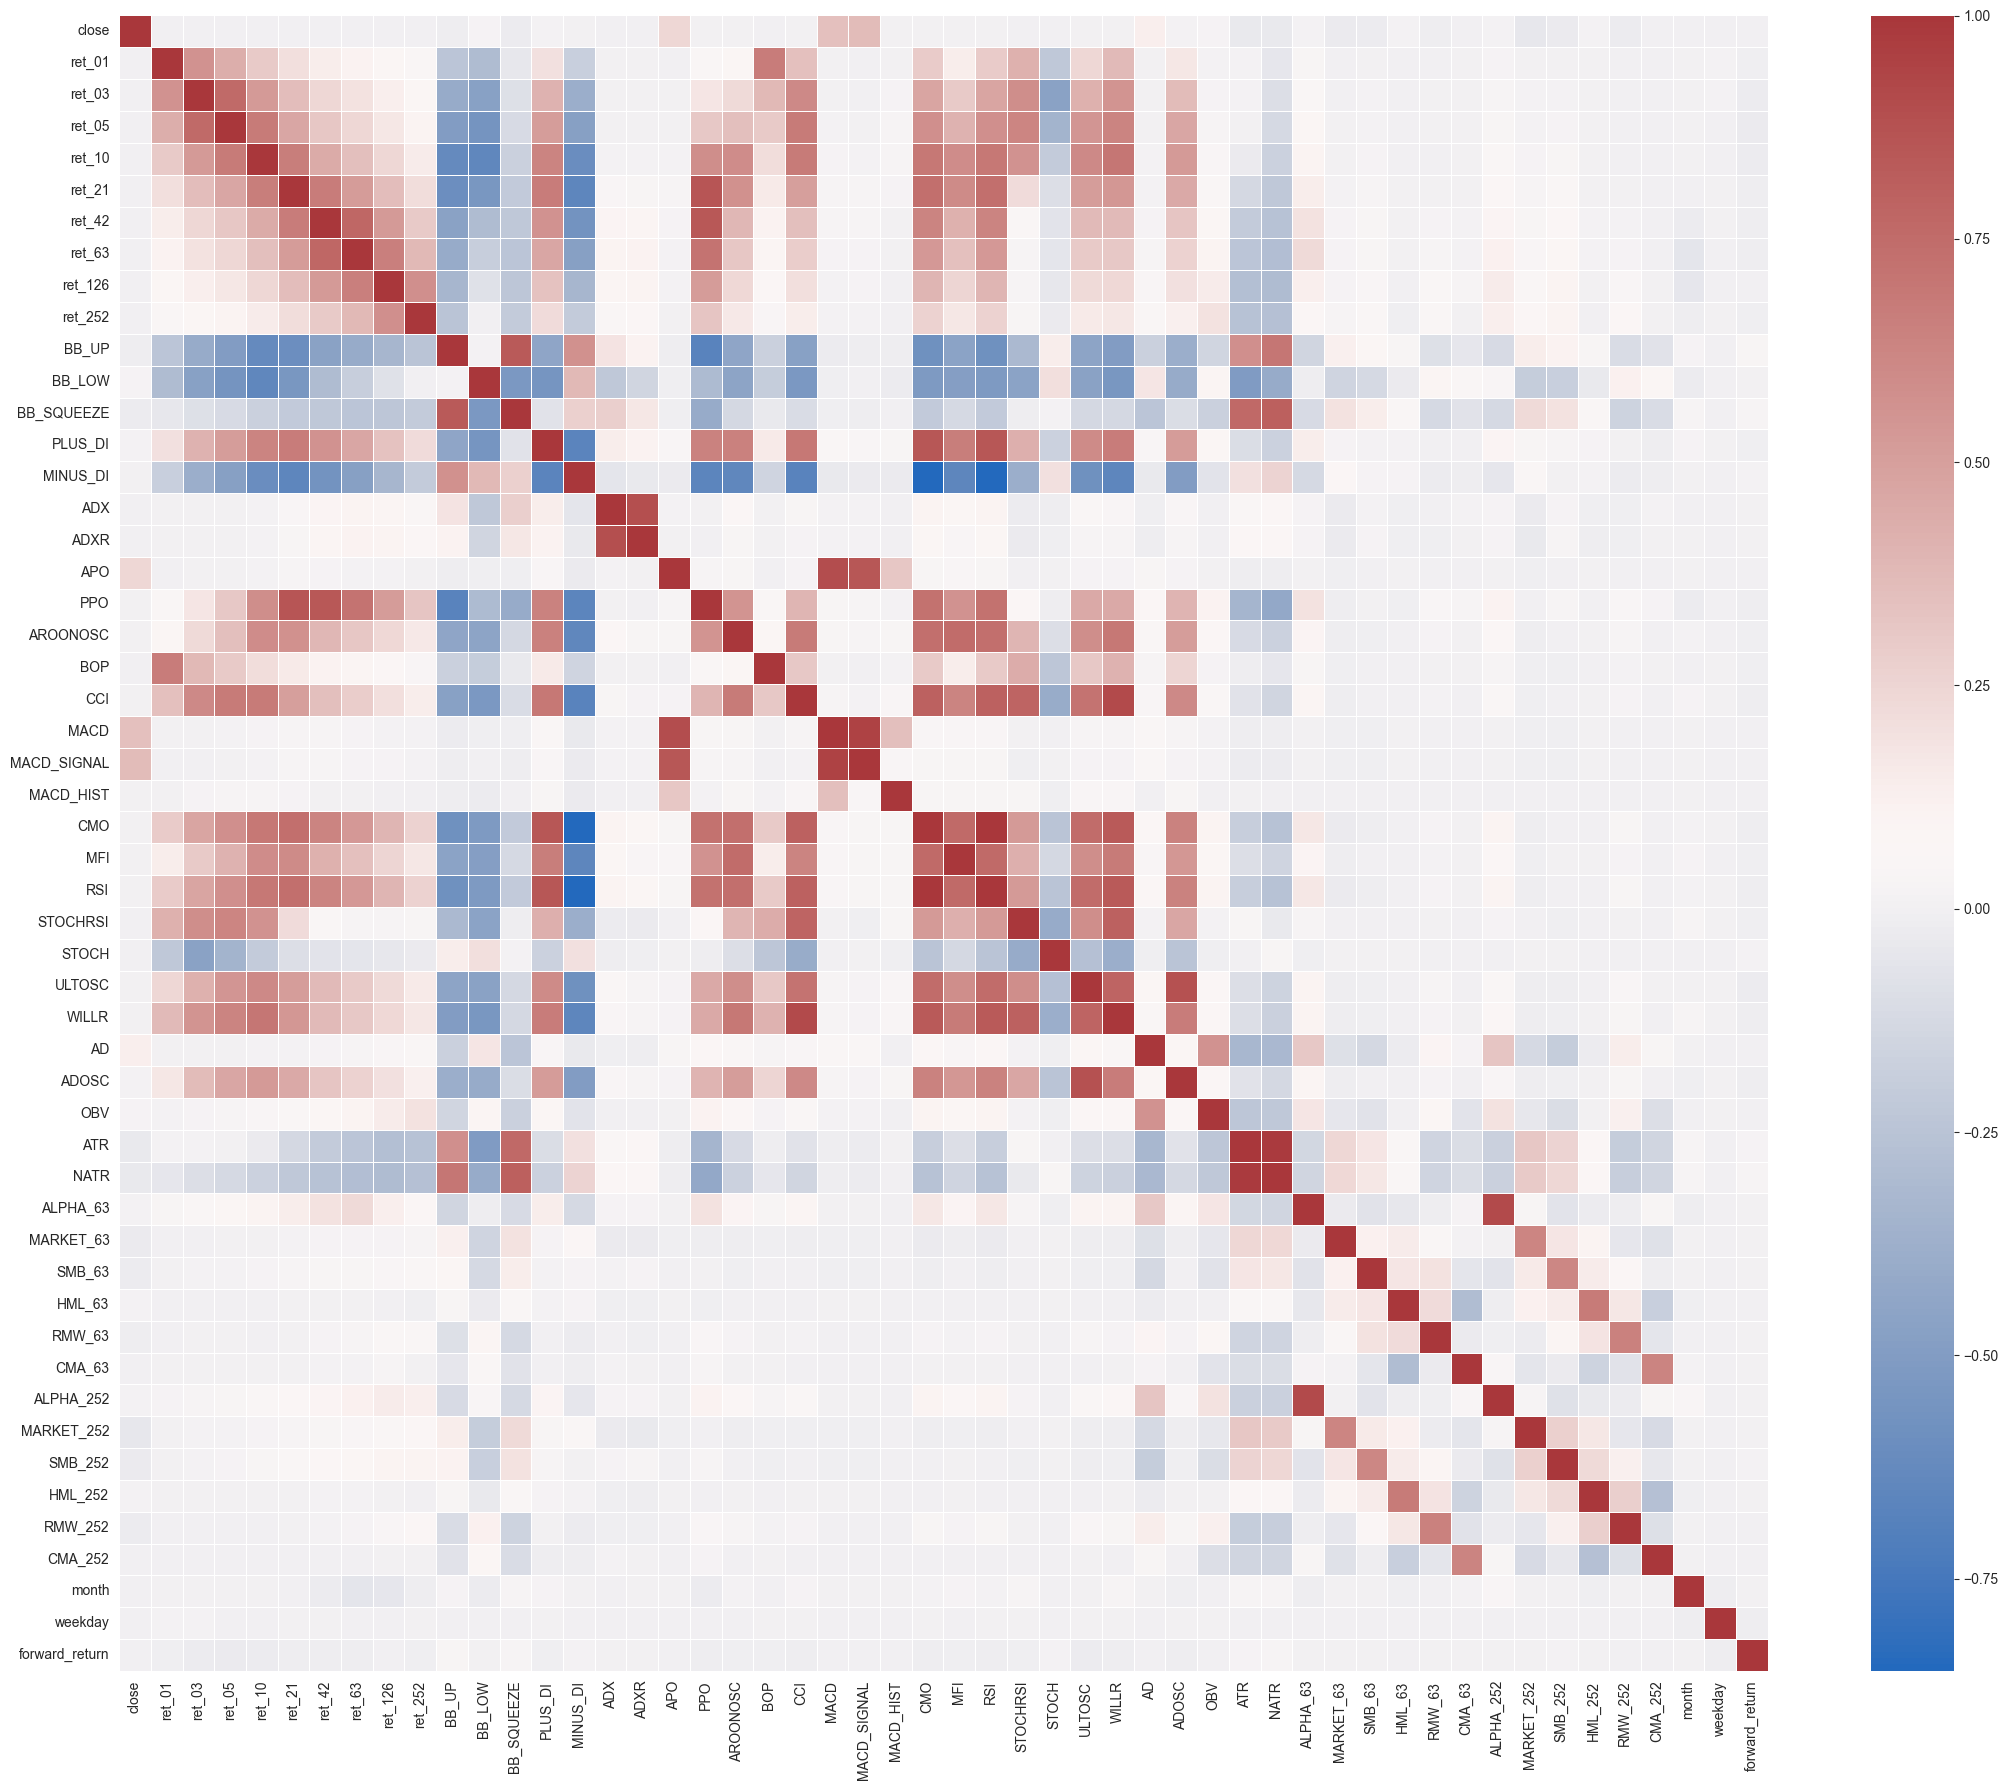

In [8]:
fig, ax = plt.subplots(figsize=(22, 18))
sns.heatmap(feature_correlation, linewidth=.5, cmap="vlag")
fig.tight_layout();

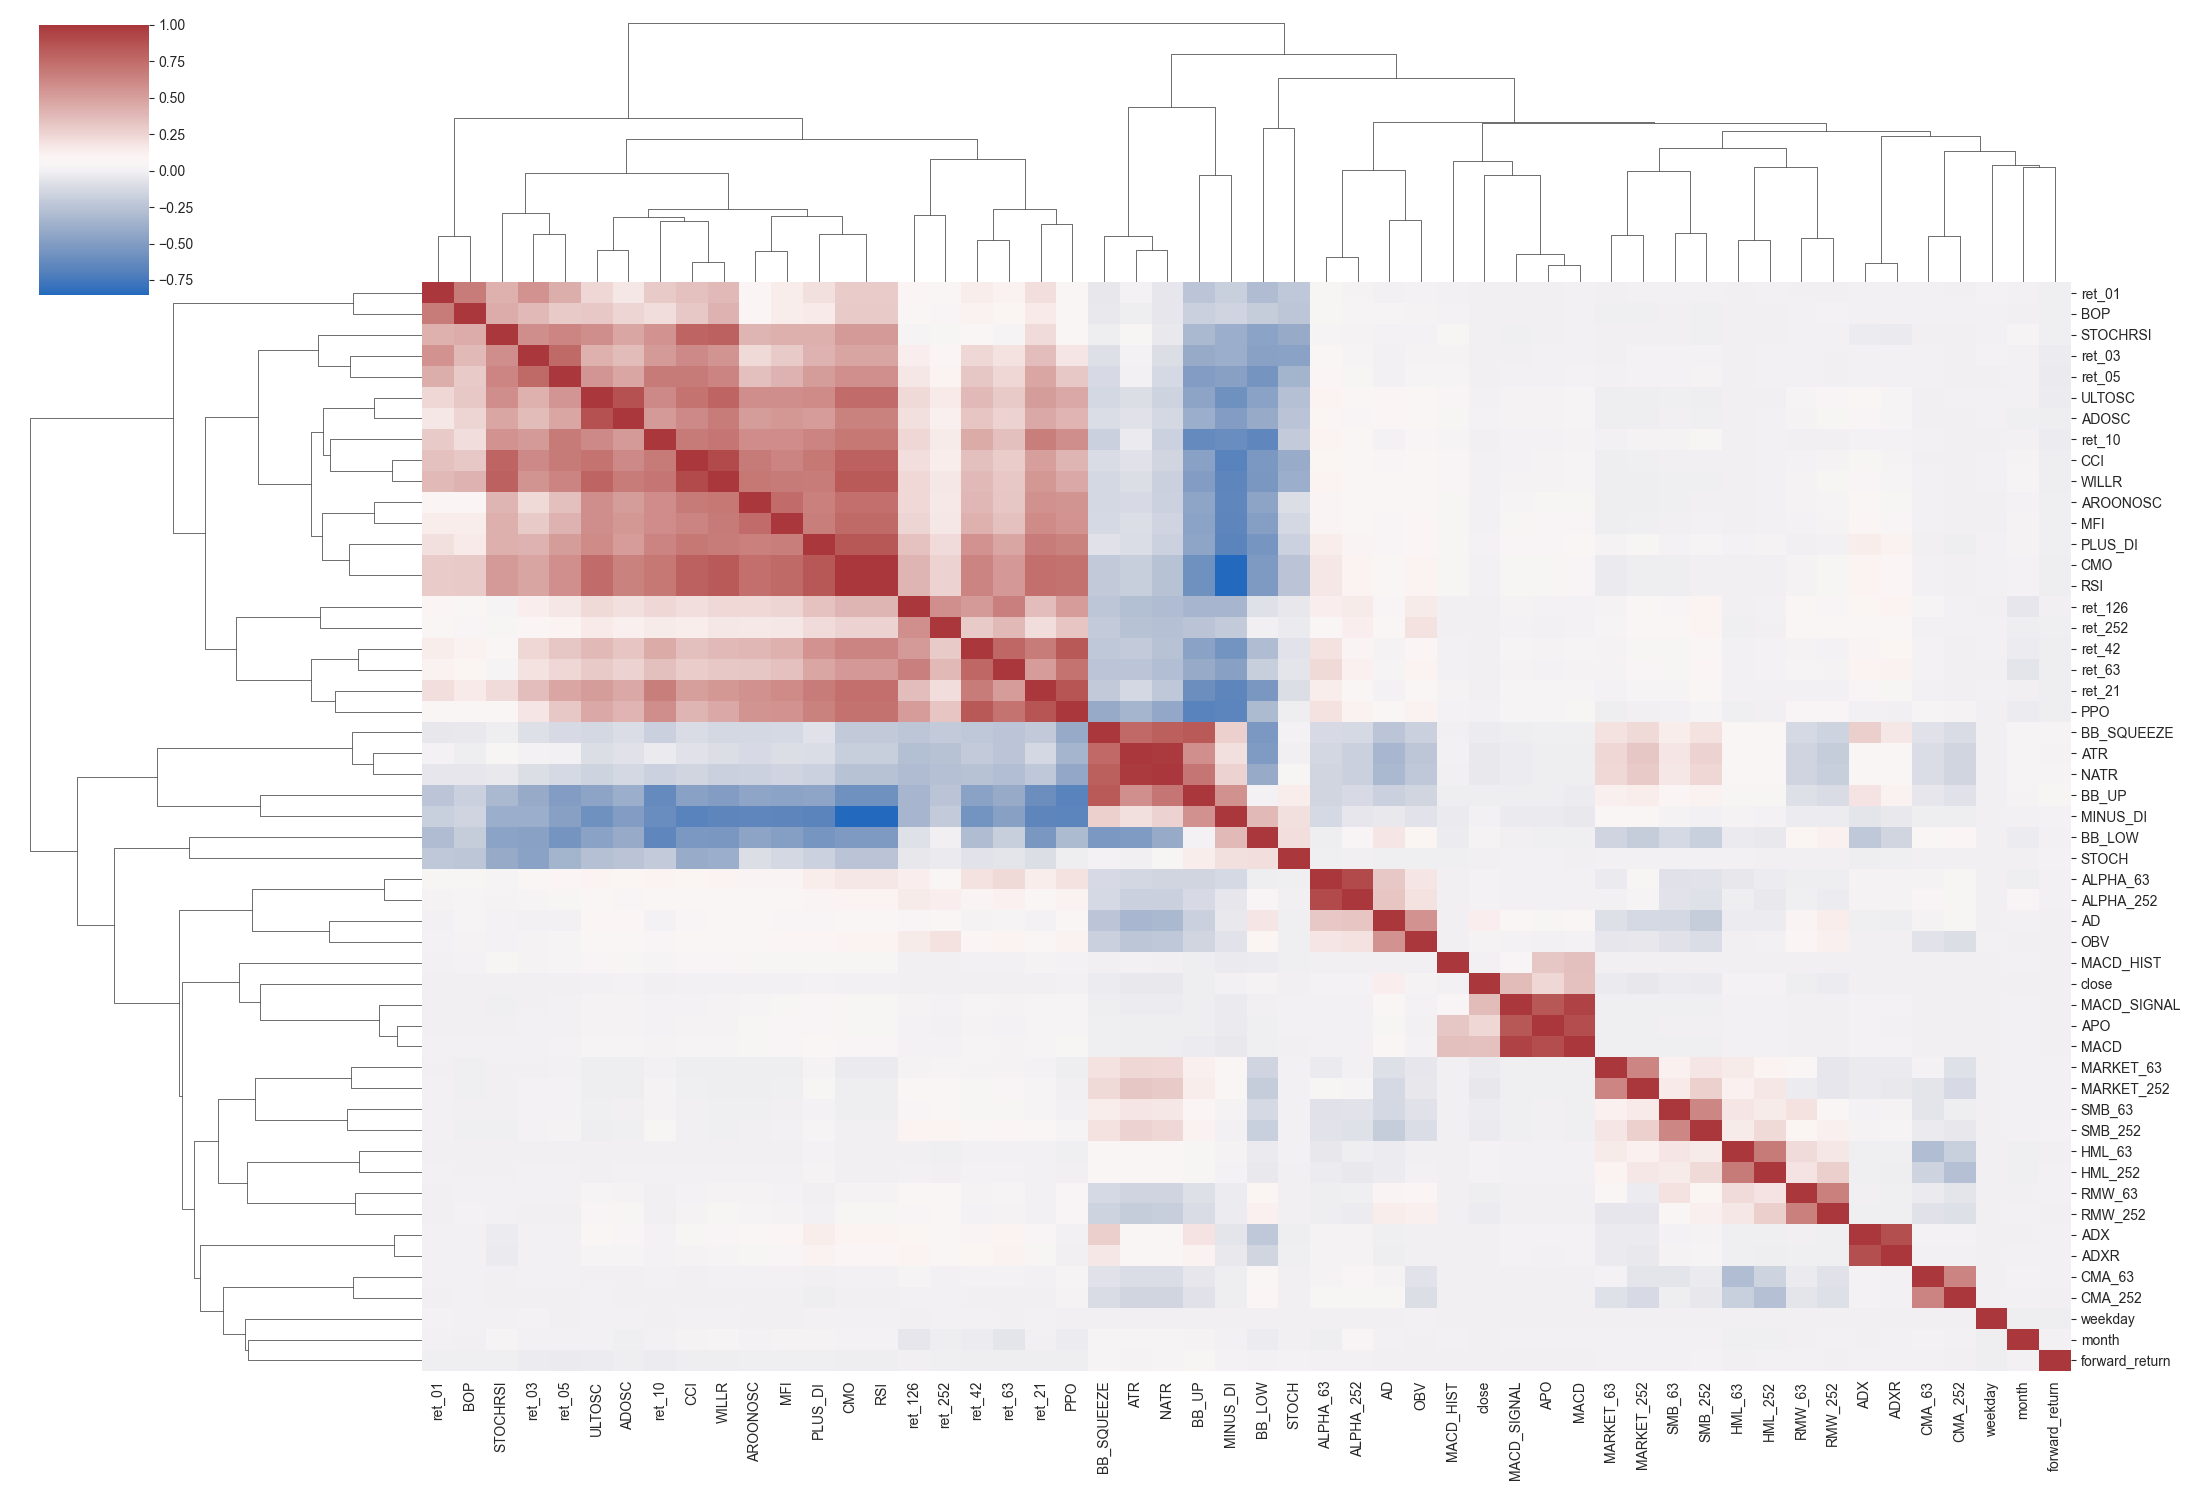

In [9]:
g = sns.clustermap(feature_correlation, figsize=(22, 15), cmap="vlag")

In [10]:
# To inspect the correlation matrix, let's isolate the unique values from the corrlation matrix, excluding the diagonal:
feature_corr_d = feature_correlation.stack().reset_index()

## Forward return correlation

Which features are most correlated with the forward returns?

In [11]:
corr_with_features = feature_correlation.drop(['forward_return'], axis=1).corrwith(feature_correlation['forward_return'], method='spearman')

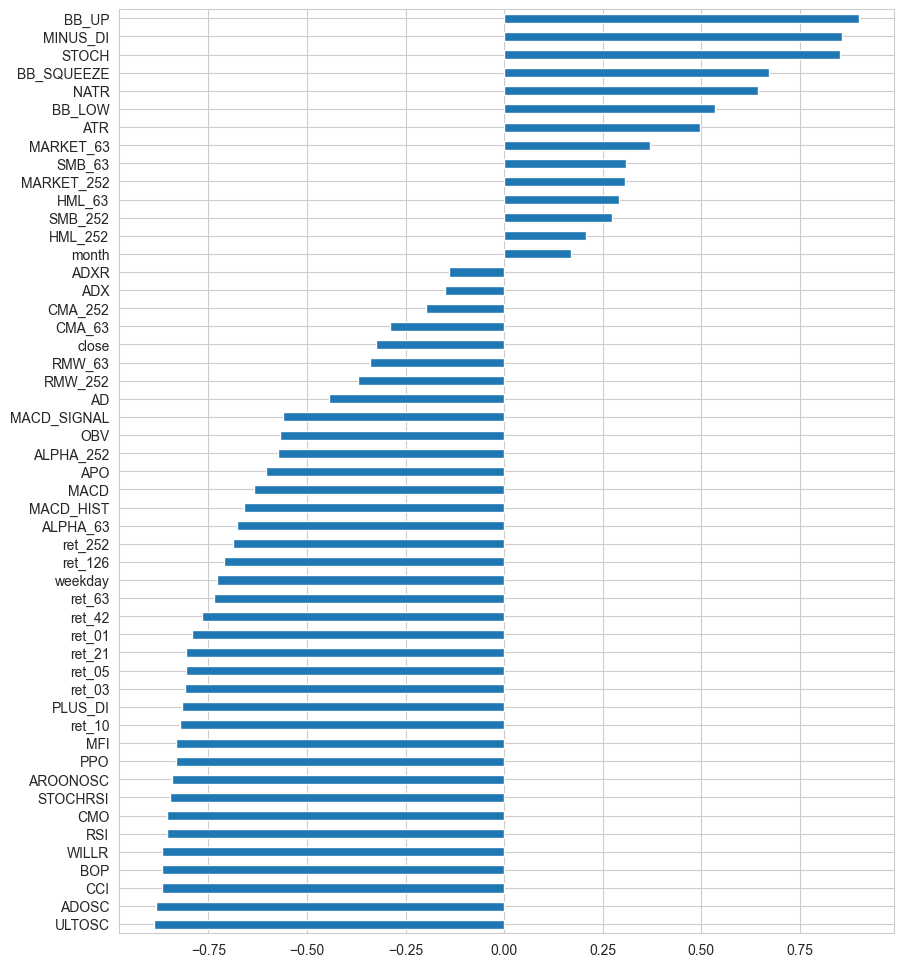

In [12]:
corr_with_features.sort_values().plot.barh(figsize=(10, 12), legend=False);

In [13]:
# save correlation
corr_with_features = corr_with_features.dropna()
corr_with_features.to_csv('forward_correlation.csv')

## Mutual Information

Let's estimate the [mutual information](https://en.wikipedia.org/wiki/Mutual_information) between each feature and the forward returns for a non-linear measure of dependency (see scikit-learn [docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) for references on computation.

> The `mutual_info_regression` can take a while, reduce the sample size as indicated below to speed up things.

In [14]:
features = data.columns.difference(['forward_return']).tolist()
print(features)

['AD', 'ADOSC', 'ADX', 'ADXR', 'ALPHA_252', 'ALPHA_63', 'APO', 'AROONOSC', 'ATR', 'BB_LOW', 'BB_SQUEEZE', 'BB_UP', 'BOP', 'CCI', 'CMA_252', 'CMA_63', 'CMO', 'HML_252', 'HML_63', 'MACD', 'MACD_HIST', 'MACD_SIGNAL', 'MARKET_252', 'MARKET_63', 'MFI', 'MINUS_DI', 'NATR', 'OBV', 'PLUS_DI', 'PPO', 'RMW_252', 'RMW_63', 'RSI', 'SMB_252', 'SMB_63', 'STOCH', 'STOCHRSI', 'ULTOSC', 'WILLR', 'close', 'month', 'ret_01', 'ret_03', 'ret_05', 'ret_10', 'ret_126', 'ret_21', 'ret_252', 'ret_42', 'ret_63', 'weekday']


In [19]:
mi = {}
for feature in features:
    print(feature)
    df = (data
          .loc[:, ['forward_return', feature]]
          .dropna()
          .sample(n=100000)) # if it takes too long or you run into resource constraints, reduce the sample size
    discrete_features = df[feature].nunique() < 20
    mi[feature] = mutual_info_regression(X=df[[feature]],
                                         y=df.forward_return,
                                         discrete_features=discrete_features)[0]

AD
ADOSC
ADX
ADXR
ALPHA_252
ALPHA_63
APO
AROONOSC
ATR
BB_LOW
BB_SQUEEZE
BB_UP
BOP
CCI
CMA_252
CMA_63
CMO
HML_252
HML_63
MACD
MACD_HIST
MACD_SIGNAL
MARKET_252
MARKET_63
MFI
MINUS_DI
NATR
OBV
PLUS_DI
PPO
RMW_252
RMW_63
RSI
SMB_252
SMB_63
STOCH
STOCHRSI
ULTOSC
WILLR
close
month
ret_01
ret_03
ret_05
ret_10
ret_126
ret_21
ret_252
ret_42
ret_63
weekday


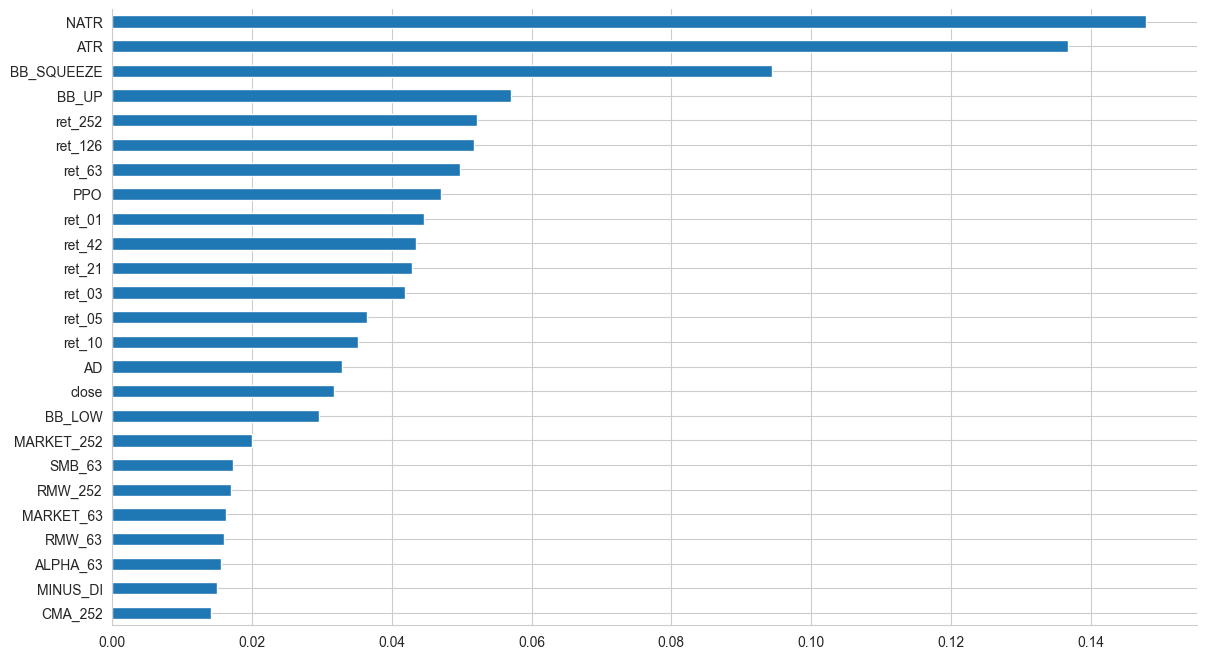

In [20]:
mi = pd.Series(mi)
mi.nlargest(25).sort_values().plot.barh(figsize=(14,8))
sns.despine();

In [21]:
mi.to_csv('mutual_info.csv')

## LightGBM Feature Importance

There will be more information on using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) in Milestone 3.

### Custom Time-Series Cross-Validation

See an example of how the `MultipleTimeSeriesCV` generates sequential, overlapping time periods for training and test in cells 11-13 [here](https://github.com/stefan-jansen/machine-learning-for-trading/blob/master/07_linear_models/05_predicting_stock_returns_with_linear_regression.ipynb).

In [22]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        """Generate the positional indices for the train-test splits for each fold"""
        unique_dates = X.index.get_level_values(self.date_idx).unique() # get unique dates
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            # create train/test start and end indices
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


### Custom Metric for Early Stopping

We can customize how LightGBM measures cross-validation progress, and will use the information coefficient. See LightGBM [docs](https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py).

> Keep in mind that early-stopping introduces lookahead bias, so do not use this to select between different model.

In [23]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True # whether to maximize or minimize the metric
    metric_name = 'ic'
    ic = spearmanr(preds, train_data.get_label())[0]
    return metric_name, ic, is_higher_better 

### CV Parameters

In [24]:
categoricals = ['month', 'weekday']

In [25]:
train_length = 9 * YEAR
test_length = YEAR
n_splits = 1

In [26]:
params = dict(boosting='gbdt',
              objective='regression',
              verbose=-1,
              learning_rate=0.01,
#               device='gpu', # uncomment if using GPU
#               max_bins=63,  # uncomment if using GPU
              metric='None')

In [27]:
num_boost_round = 5000

### Create binary Datasets

See LightGBM [docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html#lightgbm.Dataset) on the `lgb.Dataset`.

In [28]:
fwd_returns = data.filter(like='forward').columns.tolist()
features = data.columns.difference(fwd_returns).tolist()

In [29]:
lgb_data = lgb.Dataset(data=data.loc[:, features],
                       label=data[fwd_returns],
                       categorical_feature=categoricals,
                       free_raw_data=False)

In [30]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          lookahead=1,
                          test_period_length=test_length,
                          train_period_length=train_length)

### Cross-validation loop

In [31]:
for train_idx, test_idx in cv.split(X=data):
    start = time()
    lgb_train = lgb_data.subset(train_idx.tolist()).construct()
    lgb_test = lgb_data.subset(test_idx.tolist()).construct()
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      num_boost_round=num_boost_round,
                      valid_sets=[lgb_train, lgb_test],
                      valid_names=['train', 'valid'],
                      feval=ic_lgbm,
                      callbacks = [lgb.early_stopping(500), lgb.record_evaluation(evals_result)],
                      # evals_result=evals_result,
                      # early_stopping_rounds=500,
                      # verbose_eval=100
    )
    model.save_model('lgb_model.txt')

Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1]	train's ic: 0.0708131	valid's ic: -0.0106827


We can persist the model to generate predictions later:

In [32]:
model = lgb.Booster(model_file='lgb_model.txt')

### Generate and evaluate predictions

In [33]:
# select test features and label
test_set = data.iloc[test_idx, :]
X_test = test_set.loc[:, model.feature_name()]
y_test = test_set.loc[:, fwd_returns[0]]

# make predictions
y_pred = model.predict(X_test)
cv_preds = y_test.to_frame('y_test').assign(y_pred=y_pred)

# compute daily correlation
by_day = cv_preds.groupby(level='date')
ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x.y_pred)[0])
daily_ic_mean = ic_by_day.mean()
daily_ic_std = ic_by_day.std()
daily_ic_median = ic_by_day.median()
ic = spearmanr(cv_preds.y_test, cv_preds.y_pred)[0]
print(f'Overall IC: {ic:6.2%} | Average Daily IC: {daily_ic_mean: 6.2%} | Coefficient of Variation for daily IC: {daily_ic_std/daily_ic_mean: 5.2} | Median Daily IC: {daily_ic_median: 6.2%}')

Overall IC: -1.07% | Average Daily IC: -0.24% | Coefficient of Variation for daily IC: -3.6e+01 | Median Daily IC:  0.20%


While the daily average of the IC is positive at 0.028, it is also quite volatile. In other words, predictions will do quite poorly occasionally (and much better otherwise).

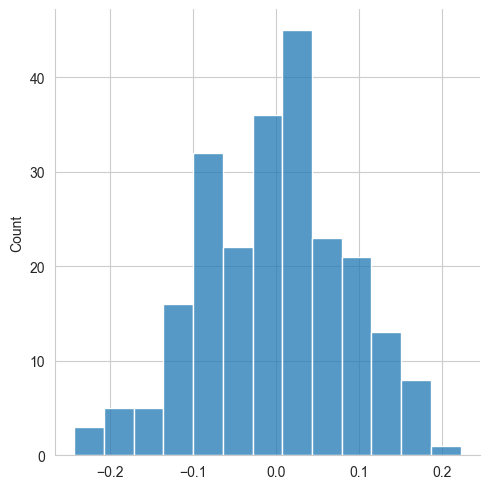

In [34]:
sns.displot(ic_by_day);

Higher momemts (Skew and Kurtosis) confirm that, while only slightly negatively skewed, but has significantly fatter tails than a normal distribution (pandas uses [Fisher's definition](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.kurtosis.html)).

In [35]:
pd.Series({'Mean': ic_by_day.mean(), 
           'Std. Dev': ic_by_day.std(), 
           'Median': ic_by_day.median(), 
           'Skew': ic_by_day.skew(), 
           'Kurtosis': ic_by_day.kurtosis()}).apply(lambda x: f'{x:.4f}')

Mean        -0.0024
Std. Dev     0.0871
Median       0.0020
Skew        -0.0669
Kurtosis    -0.2202
dtype: object

### Compute Feature Importance

In [36]:
def get_fi(model):
    """Compute LightGBM feature imporance"""
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

In [37]:
fi = get_fi(model)
fi.to_csv('feature_importance.csv')

In [38]:
cv_result = pd.DataFrame({'Train Set': evals_result['train']['ic'], 
                          'Validation Set': evals_result['valid']['ic']})

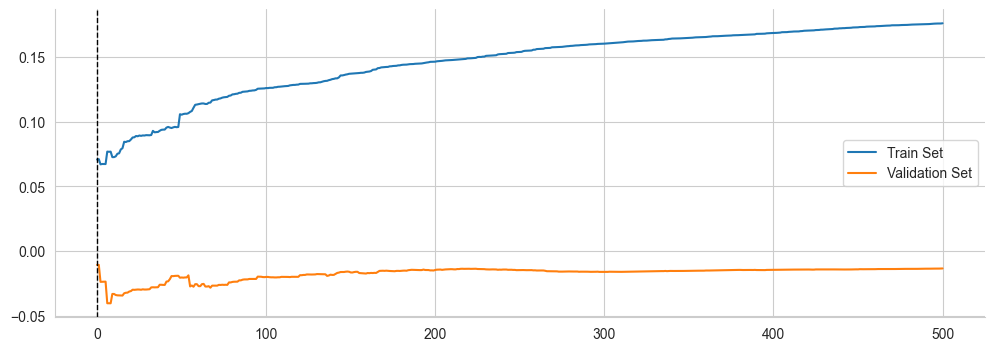

In [39]:
ax = cv_result.plot(figsize=(12, 4))
ax.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1)
sns.despine();

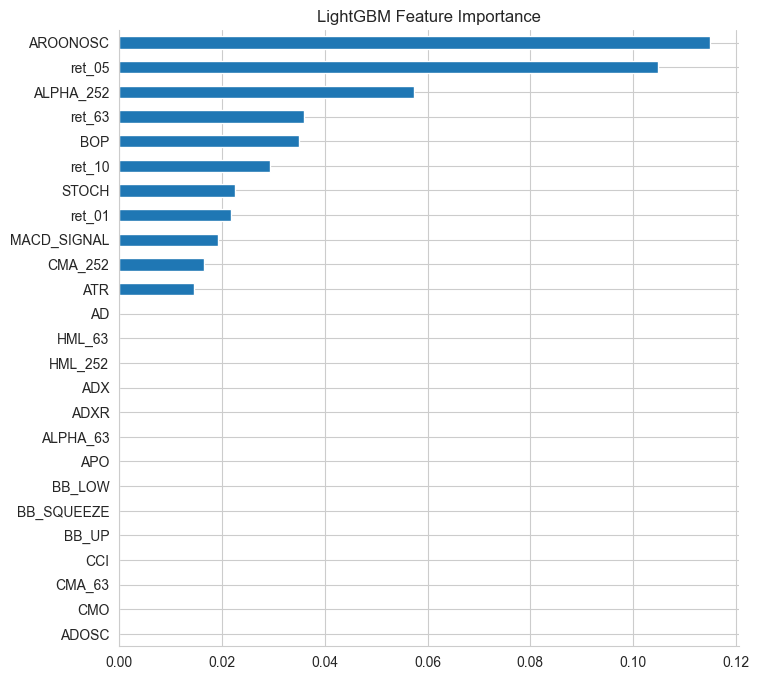

In [40]:
fi.drop(categoricals).nlargest(25).sort_values().plot.barh(figsize=(8, 8),
                                        title='LightGBM Feature Importance')
sns.despine();

## SHAP Values

See SHAP Values [GitHub repo](https://github.com/slundberg/shap) for docs and links to papers.

In [41]:
shap.initjs()

In [42]:
model = lgb.Booster(model_file='lgb_model.txt')

In [43]:
explainer = shap.TreeExplainer(model)

In [44]:
# workaround for SHAP version 0.35: https://github.com/slundberg/shap/issues/794
model.params['objective'] = 'regression'

In [45]:
shap_values = explainer.shap_values(data.iloc[test_idx, :].loc[:, model.feature_name()])

In [46]:
np.save('shap_values.npy', shap_values)

In [47]:
shap_values = np.load('shap_values.npy')

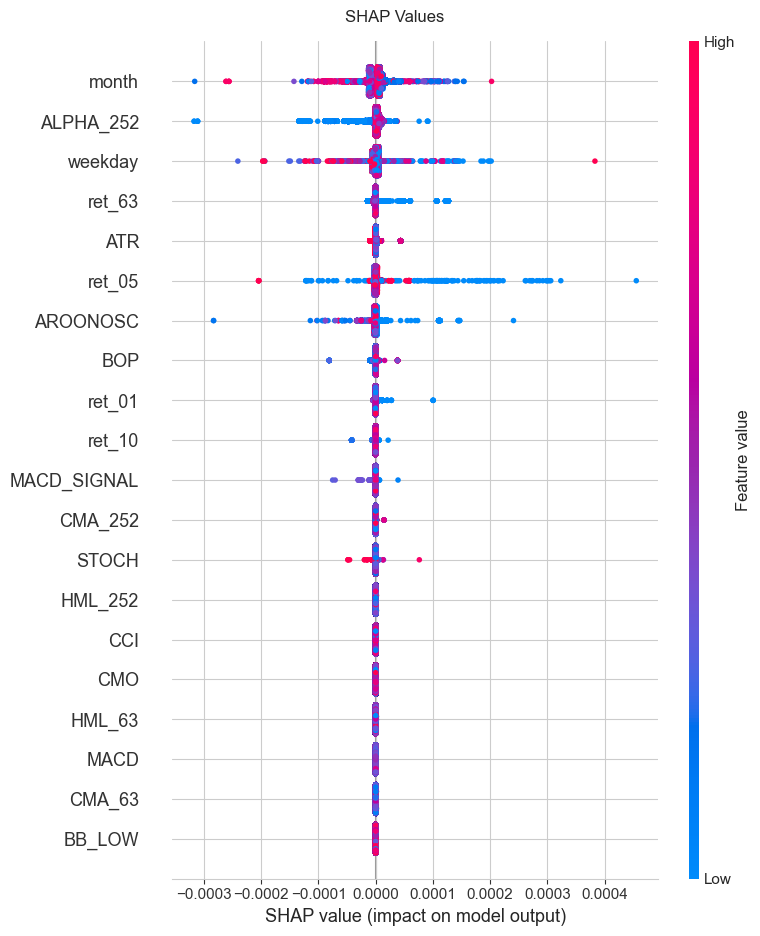

In [48]:
shap.summary_plot(shap_values,
                  data
                  .iloc[test_idx, :]
                  .loc[:, model.feature_name()],
                  show=False)

plt.gcf().suptitle('SHAP Values')
plt.gcf().tight_layout()

In [49]:
shap_values = pd.DataFrame(shap_values, columns=features)

In [50]:
shap_summary = np.abs(shap_values).mean()
shap_summary /= shap_summary.sum()

In [51]:
shap_summary.nlargest(20)

month          0.451269
ALPHA_252      0.225549
weekday        0.115064
ret_63         0.062491
ATR            0.044249
ret_05         0.037173
AROONOSC       0.034202
BOP            0.010439
ret_01         0.007549
ret_10         0.004761
MACD_SIGNAL    0.004674
CMA_252        0.001304
STOCH          0.001274
AD             0.000000
ADOSC          0.000000
ADX            0.000000
ADXR           0.000000
ALPHA_63       0.000000
APO            0.000000
BB_LOW         0.000000
dtype: float64

In [52]:
shap_summary.to_csv('shap_values.csv')

## Comparison

In [53]:
mi = pd.read_csv('mutual_info.csv', index_col=0)
fwd_corr = pd.read_csv('forward_correlation.csv', index_col=0)

mi.columns = ["Mutual Information"]
fwd_corr.columns = ['Information Coefficient']

In [54]:
stats = (mi
         .join(fwd_corr)
         .join(fi.to_frame('Feature Importance'))
         .join(shap_summary.to_frame('SHAP Values')))

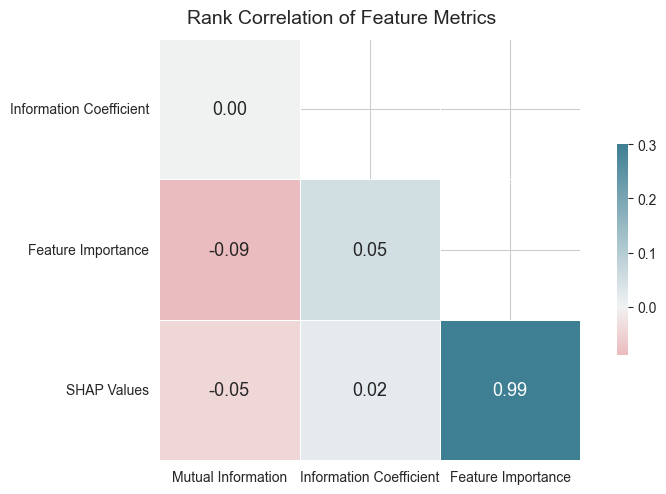

In [55]:
cols = {'Information Coefficient': stats['Information Coefficient'].abs()}

corr = stats.assign(**cols).corr('spearman')

mask = np.triu(np.ones_like(corr, dtype=np.bool_))
corr = corr.iloc[1:, :-1]
mask = mask[1:, :-1]

fig, ax = plt.subplots(figsize=(8, 5))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, mask=mask,
            cmap=cmap,
            vmax=.3, center=0,
            square=True, linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True, fmt='.2f',
            annot_kws={"size": 13})

plt.xticks(rotation=0)
fig.suptitle('Rank Correlation of Feature Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.92)

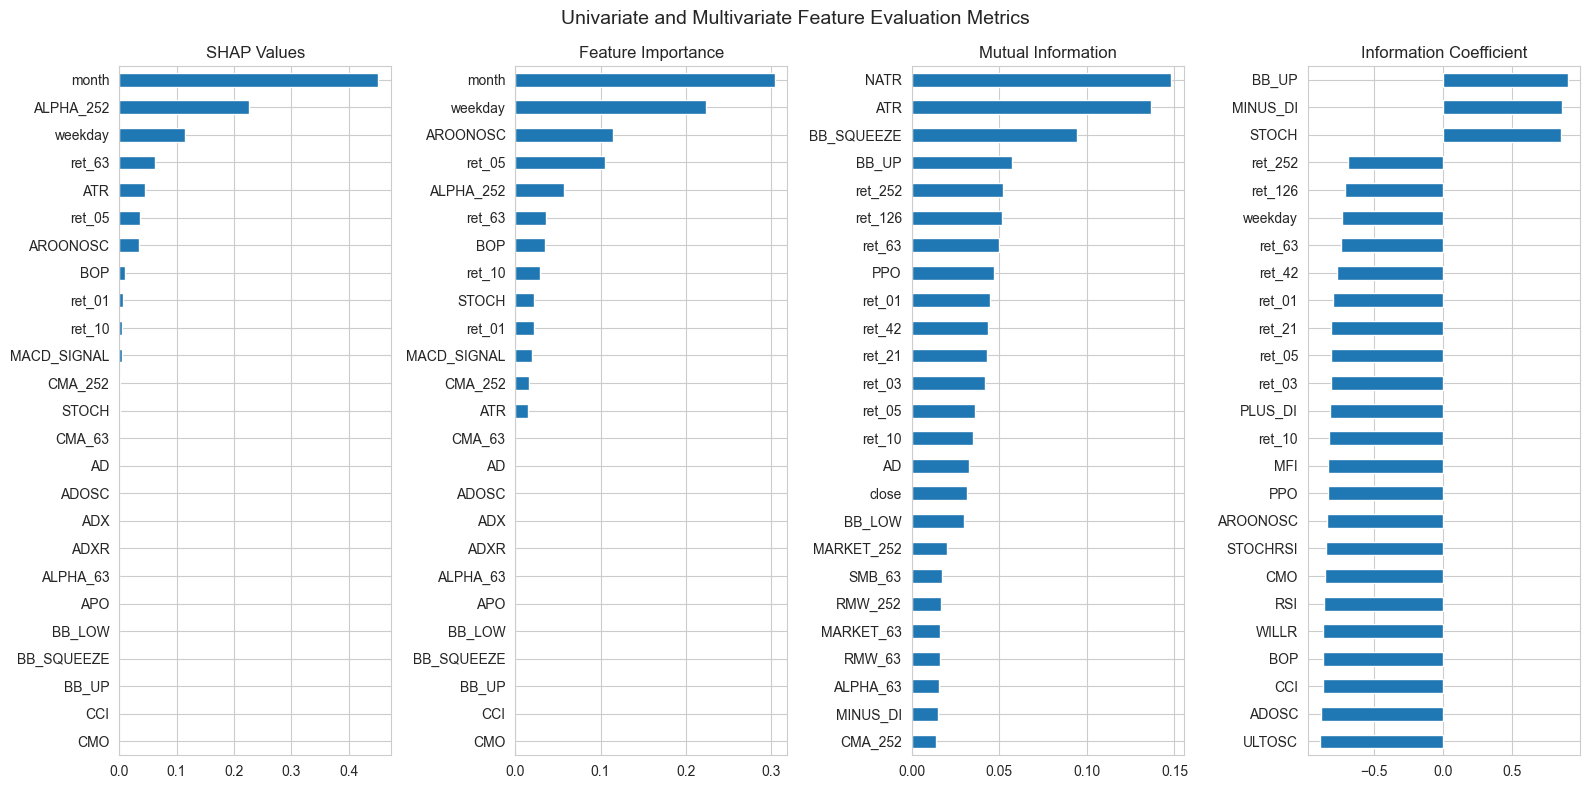

In [56]:
top_n = 25
fig, axes = plt.subplots(ncols=4, figsize=(16, 8))

shap_summary.nlargest(top_n).sort_values().plot.barh(ax=axes[0], title='SHAP Values')
fi.nlargest(top_n).sort_values().plot.barh(ax=axes[1], title='Feature Importance')
mi["Mutual Information"].nlargest(top_n).sort_values().plot.barh(ax=axes[2], title='Mutual Information')

fwd_corr_ser = fwd_corr['Information Coefficient']
top_corr = fwd_corr_ser.abs().nlargest(top_n).index
fwd_corr_ser.loc[top_corr].sort_values().plot.barh(ax=axes[3], title='Information Coefficient')

fig.suptitle('Univariate and Multivariate Feature Evaluation Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.91);

In [57]:
top_ranked = stats.drop('Mutual Information', axis=1).abs().rank(ascending=False).mean(1)

In [58]:
top_ranked.to_csv('top_features.csv')

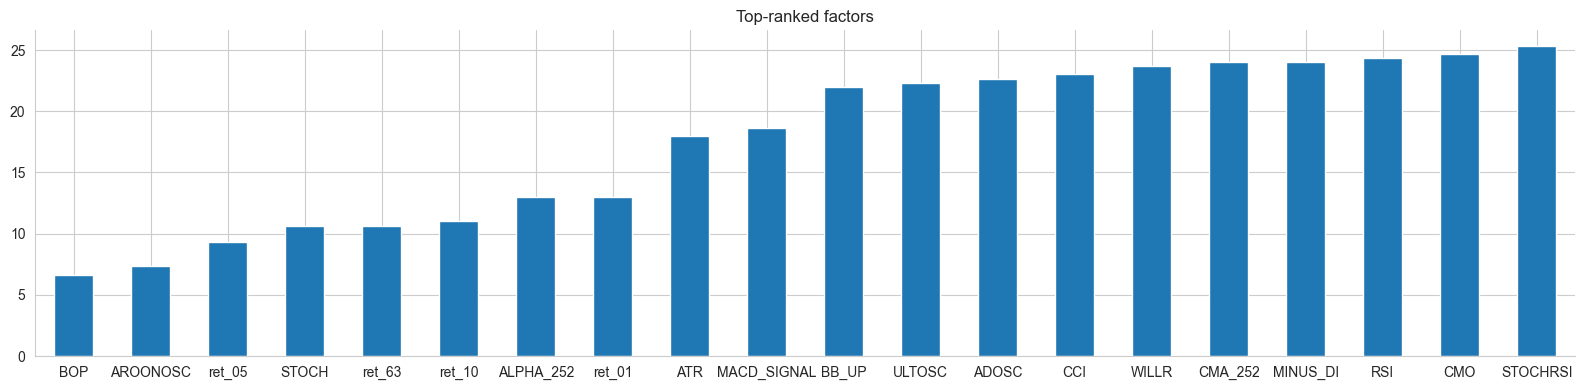

In [59]:
top_ranked.drop(categoricals).nsmallest(20).plot.bar(figsize=(16, 4), rot=0, title='Top-ranked factors')
sns.despine()
plt.tight_layout();

## Alphalens Analysis

Alphalens is a Python Library (originally developed by Quantopian) for performance analysis of predictive (alpha) stock factors. Alphalens works great with the Zipline open source backtesting library, and Pyfolio which provides performance and risk analysis of financial portfolios. 

The main function of Alphalens is to surface the most relevant statistics and plots about an alpha factor, including:

- Returns Analysis
- Information Coefficient Analysis
- Turnover Analysis
- Grouped Analysis

See Alphalens [docs](https://alphalens.ml4trading.io) and [example notebooks](https://github.com/stefan-jansen/alphalens-reloaded/tree/master/alphalens/examples) for additional detail.

In [60]:
tickers = data.index.unique('ticker')

### Get trade prices

We need market prices for the relevant period:

In [61]:
def get_trade_prices(tickers):
    return (pd.read_hdf(DATA_STORE, 'us_stocks')
              .loc[idx[tickers, '2006':'2017'], 'open']
              .unstack('ticker')
              .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

trade_prices = get_trade_prices(tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 470 entries, A to ZMH
dtypes: float64(470)
memory usage: 10.9 MB


### Select factor

We also need the factor signals that we want to evaluate:

In [62]:
alpha = 'ATR'

In [63]:
factor = (data[alpha]
          .unstack('ticker')
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())

### Generate Alphalens input data

With a signal and pricing data creating a factor "tear sheet" is a two step process:
1. Bring data into the right format
2. Select desired tearsheet.

In [64]:
factor_data = utils.get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   max_loss=0.35,
                                                   periods=(1, 5, 10)).sort_index()
factor_data.info()

Dropped 32.4% entries from factor data: 32.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1377315 entries, (Timestamp('2006-01-03 00:00:00+0000', tz='UTC'), 'A') to (Timestamp('2017-12-14 00:00:00+0000', tz='UTC'), 'ZION')
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   1D               1377315 non-null  float64
 1   5D               1377315 non-null  float64
 2   10D              1377315 non-null  float64
 3   factor           1377315 non-null  float64
 4   factor_quantile  1377315 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 57.8+ MB


### Create Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.000739,0.076282,0.016792,0.007940,276130,20.048428
2,0.011481,0.091113,0.021739,0.010195,275143,19.976766
3,0.013329,0.106953,0.026039,0.012594,275066,19.971176
4,0.015718,0.132883,0.031610,0.015600,275143,19.976766
5,0.018992,0.367297,0.045370,0.025029,275833,20.026864


Returns Analysis


,1D,5D,10D
Ann. alpha,-0.026,-0.032,-0.034
beta,0.476,0.494,0.479
Mean Period Wise Return Top Quantile (bps),1.683,1.486,1.335
Mean Period Wise Return Bottom Quantile (bps),-1.234,-1.254,-1.190
Mean Period Wise Spread (bps),2.917,2.587,2.377


Information Analysis


,1D,5D,10D
IC Mean,-0.011,-0.007,-0.004
IC Std.,0.254,0.261,0.252
Risk-Adjusted IC,-0.042,-0.027,-0.017
t-stat(IC),-2.300,-1.506,-0.913
p-value(IC),0.022,0.132,0.361
IC Skew,-0.087,-0.103,-0.099
IC Kurtosis,-0.221,-0.369,-0.342


Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.050,0.128,0.181
Quantile 2 Mean Turnover,0.110,0.281,0.388
Quantile 3 Mean Turnover,0.121,0.310,0.423
Quantile 4 Mean Turnover,0.099,0.260,0.362
Quantile 5 Mean Turnover,0.041,0.109,0.155


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.994,0.97,0.943


<Figure size 640x480 with 0 Axes>

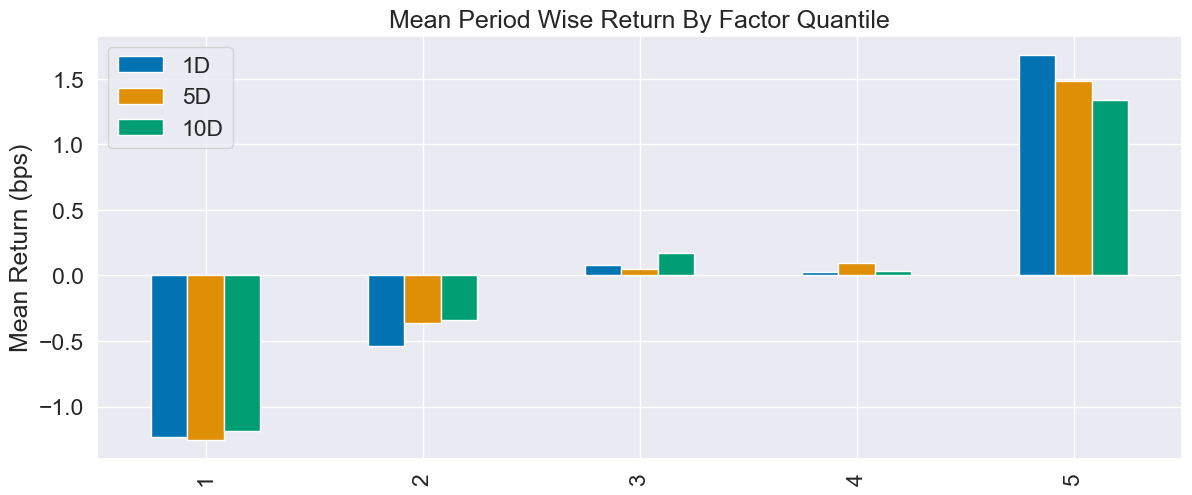

In [65]:
create_summary_tear_sheet(factor_data)

Returns Analysis


,1D,5D,10D
Ann. alpha,-0.026,-0.032,-0.034
beta,0.476,0.494,0.479
Mean Period Wise Return Top Quantile (bps),1.683,1.486,1.335
Mean Period Wise Return Bottom Quantile (bps),-1.234,-1.254,-1.190
Mean Period Wise Spread (bps),2.917,2.587,2.377


<Figure size 640x480 with 0 Axes>

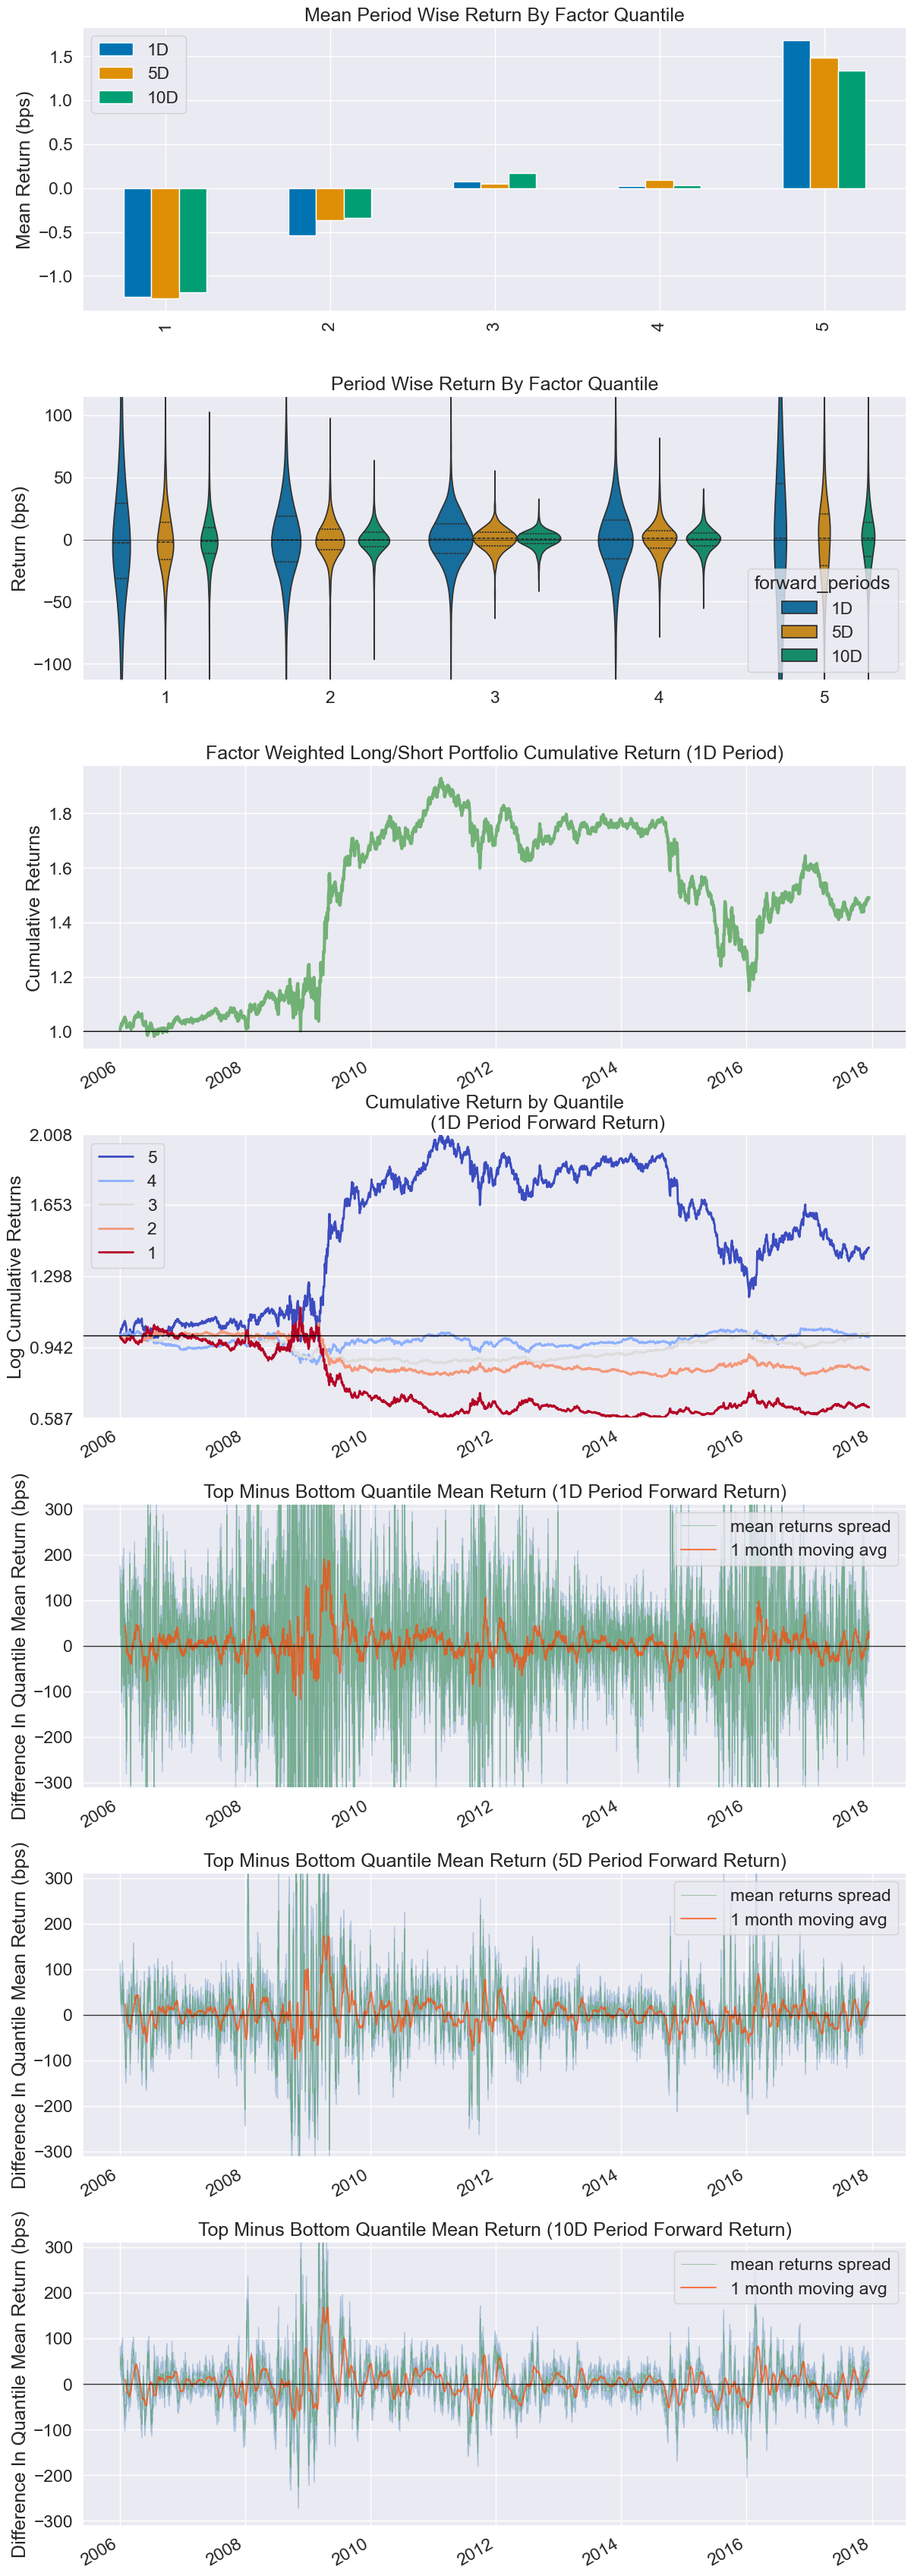

In [66]:
create_returns_tear_sheet(factor_data)